# Pose Estimation Workshop

In this notebook, we will explore OpenPose, a pose estimation library. OpenPose detects human body keypoints using single images.

https://github.com/CMU-Perceptual-Computing-Lab/openpose

It uses a multi-person pose estimation model. Given an input colour image, the model returns two outputs:
1. Confidence maps of body part locations ("keypoints")
2. Part affinity heatmaps for each keypoint pair ("associations" between body parts). 

![multipose](https://github.com/ZheC/Realtime_Multi-Person_Pose_Estimation/raw/master/readme/arch.png)

More details on the model are here: https://github.com/ZheC/Realtime_Multi-Person_Pose_Estimation

## Example Use Cases

Pose estimation models can be used in video pre-processing to extract poses for further analysis. For example, in this paper, the sequence of poses are fed into a Hidden Markov Model for predicting future poses. Other use cases are gaming, medical diagnosis, robotic control, driver assistant, etc (see: https://en.wikipedia.org/wiki/Articulated_body_pose_estimation)

![pose-dmm-dicta-17](assets/pose-dmm-dicta-17.png)

Source: Toyer et. al., Human Pose Forecasting via Deep Markov Models, 2017

### Other Solutions

https://github.com/facebookresearch/VideoPose3D

## Running OpenPose from the Command Line

We will be exploring the OpenPose Demo command line application to extract poses from a video file.

The poses will be saved to JSON.

### Setup (Windows only)

1. Download OpenPose binaries from https://github.com/CMU-Perceptual-Computing-Lab/openpose/releases. 
   Example: openpose-1.5.1-binaries-win64-only_cpu-python-flir-3d.zip

2. Unzip the file

3. The pre-trained models are not included in the zip file because they are quite large. Download them:

```
cd openpose-1.5.1-win64-only_cpu-python-flir-3d\openpose\models

getModels.bat
```

The download should take about 5-10 minutes.

#### Non-Windows?

Unfortunately, installation for non-Windows involves building from source. To save time, you can partner with a classmate who has a Windows machine. 

Later, if you plan to do more work using OpenPose, you may wish to try these instructions at home (in your own time): https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/installation.md#openpose-from-other-projects-ubuntu-and-mac

### Generate Keypoints from Video (Windows only)

1. <font color='red'>**[Important] run the demo from the top level openpose folder, not the subfolders:**</font>

```
cd openpose-1.5.1-win64-only_cpu-python-flir-3d\openpose

bin\OpenPoseDemo.exe --video examples\media\video.avi --part_candidates --write_json output
```

   The above command runs the demo for face and hand keypoint detection, and writes the results as JSON format in a folder called `output`. The `part_candidates` option will include predicted poses.


2. The video will run very slowly because this is the CPU version. 

    Wait a few minutes to see keypoints appearing in the `output` folder.  There's no easy way to stop the demo. <font color='red'>**Stop the demo after about 3-4 frames, because it consumes a lot of memory (use Ctrl+C from Command Prompt).**</font>

    If you have an NVidia GPU, you may want to download the GPU version (which run significantly faster and is recommended).


3. To optionally capture in COCO format, which captures more keypoints:

```
bin\OpenPoseDemo.exe --video examples\media\video.avi --write_coco_json output.coco.json
```


4. Other options are documented at https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/demo_overview.md, and also here:

```
bin\OpenPoseDemo.exe --help
```

## Exploring keypoints

The following section shows how to take the keypoints and plot them. 

For this section, we will use pre-extracted keypoint data in the HSS github repository, under the `data\openpose` folder.  This is the same set of keypoints extracted from the earlier video (but run from a GPU to speed things up).

The output format is documented here:
https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import sys
import numpy as np
from sklearn.metrics.pairwise import paired_distances

# requires: conda install opencv
import cv2

plt.style.use('seaborn-white')

In [2]:
# load the 200th frame
frame = json.load(open('./data/openpose/video_000000000200_keypoints.json', 'rb'))
frame

{'version': 1.2,
 'people': [{'pose_keypoints_2d': [0,
    0,
    0,
    51.4158,
    149.457,
    0.91052,
    76.9174,
    147.491,
    0.893503,
    102.333,
    180.81,
    0.883591,
    102.348,
    217.956,
    0.211567,
    22.0453,
    153.333,
    0.866329,
    4.38107,
    202.29,
    0.831755,
    22.0122,
    225.811,
    0.729868,
    63.169,
    227.773,
    0.801695,
    82.7451,
    227.694,
    0.807339,
    84.8005,
    278.683,
    0.850238,
    70.9845,
    323.821,
    0.852812,
    45.5556,
    229.724,
    0.771841,
    65.1485,
    280.619,
    0.790963,
    71.0001,
    331.561,
    0.735317,
    0,
    0,
    0,
    0,
    0,
    0,
    59.2899,
    118.068,
    0.790251,
    33.7925,
    120.036,
    0.815352,
    84.6441,
    351.186,
    0.336659,
    74.9327,
    349.186,
    0.281496,
    69.0845,
    337.412,
    0.385363,
    76.9073,
    351.132,
    0.659874,
    80.8557,
    349.201,
    0.680061,
    67.073,
    333.516,
    0.707275],
   'face_keyp

In [3]:
# count how many people
len(frame['people'])

13

In [4]:
# what keypoints are logged for each person
frame['people'][0].keys()

dict_keys(['pose_keypoints_2d', 'face_keypoints_2d', 'hand_left_keypoints_2d', 'hand_right_keypoints_2d', 'pose_keypoints_3d', 'face_keypoints_3d', 'hand_left_keypoints_3d', 'hand_right_keypoints_3d'])

In [5]:
# format is x1, y1, c1, x2, y2, c2, ...
# x, y coordinates with a confidence
frame['people'][0]['pose_keypoints_2d']

[0,
 0,
 0,
 51.4158,
 149.457,
 0.91052,
 76.9174,
 147.491,
 0.893503,
 102.333,
 180.81,
 0.883591,
 102.348,
 217.956,
 0.211567,
 22.0453,
 153.333,
 0.866329,
 4.38107,
 202.29,
 0.831755,
 22.0122,
 225.811,
 0.729868,
 63.169,
 227.773,
 0.801695,
 82.7451,
 227.694,
 0.807339,
 84.8005,
 278.683,
 0.850238,
 70.9845,
 323.821,
 0.852812,
 45.5556,
 229.724,
 0.771841,
 65.1485,
 280.619,
 0.790963,
 71.0001,
 331.561,
 0.735317,
 0,
 0,
 0,
 0,
 0,
 0,
 59.2899,
 118.068,
 0.790251,
 33.7925,
 120.036,
 0.815352,
 84.6441,
 351.186,
 0.336659,
 74.9327,
 349.186,
 0.281496,
 69.0845,
 337.412,
 0.385363,
 76.9073,
 351.132,
 0.659874,
 80.8557,
 349.201,
 0.680061,
 67.073,
 333.516,
 0.707275]

In [6]:
def keypoints_to_dataframe(keypoints):
    """Converts a flat keypoints list (x1, y1, c1, x2, y2, c2) into a pandas DataFrame"""
    return pd.DataFrame({'x': keypoints[::3], 'y': keypoints[1::3], 'c': keypoints[2::3]})

### Drawing Skeletons

The keypoints follow the BODY_25 format, which can be used to connect the points to make a skeleton

<img src='https://github.com/CMU-Perceptual-Computing-Lab/openpose/raw/master/doc/media/keypoints_pose_25.png' width=300/>

In [7]:
# Source: https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#pose-output-format-coco
Pose_part_pairs = [
    (1,8), (1,2), (1,5), (2,3), (3,4), (5,6), (6,7), (8,9), (9,10), (10,11),
    (8,12), (12,13), (13,14), (1,0), (0,15), (15,17), (0,16), (16,18), (2,17), (5,18),
    (14,19), (19,20), (14,21), (11,22), (22,23), (11,24)
]

def draw_skeleton(ax, df):
    for p, q in Pose_part_pairs:
        if df.x[p] != 0 and df.x[q] != 0 and df.y[p] != 0 and df.y[q] != 0:
            ax.plot([df.x[p], df.x[q]], [df.y[p], df.y[q]], color='red')

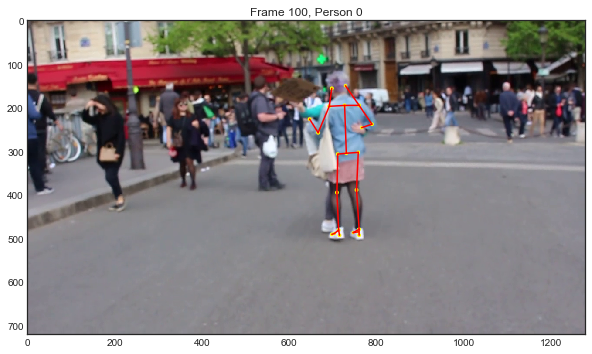

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

video = cv2.VideoCapture('./data/openpose/video.avi')

frame = json.load(open(f'./data/openpose/video_000000000100_keypoints.json', 'rb'))
df = keypoints_to_dataframe(frame['people'][0]['pose_keypoints_2d'])

for i in range(100):
    _, image = video.read()
_, image1 = video.read()

# different size dots according to probability
ax.scatter(df.x, df.y, s=df.c*10, color='yellow')
ax.set(title='Frame 100, Person 0')

# openCV uses BGR, convert to RGB
ax.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

draw_skeleton(ax, df)

### Plotting a Scene

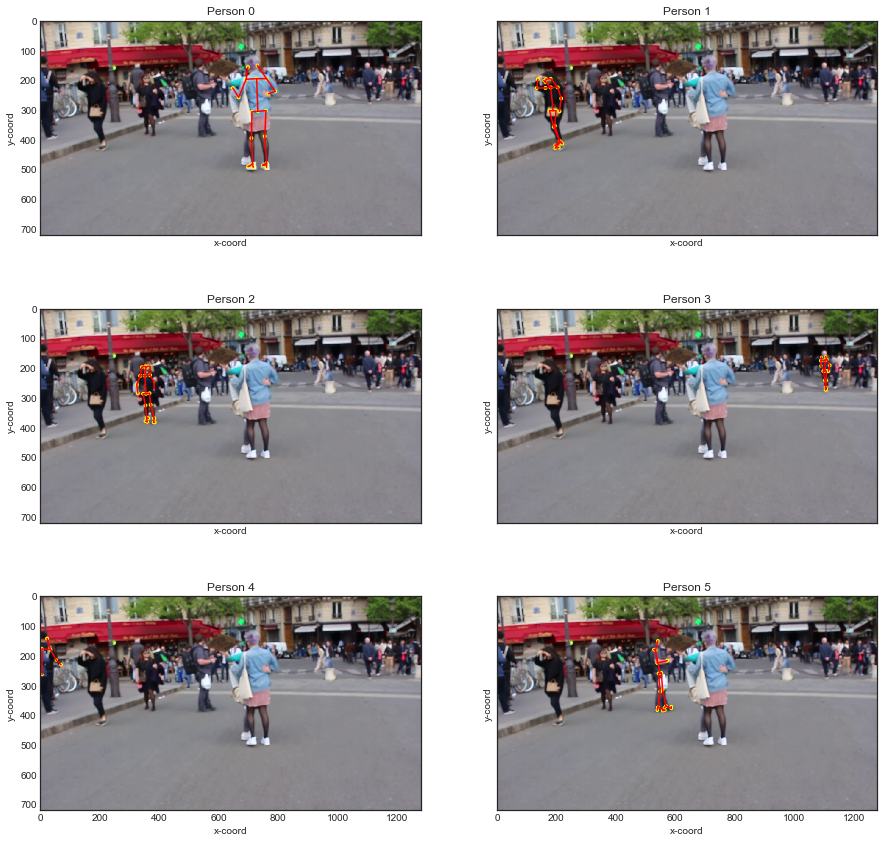

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
ax = ax.flatten()

video = cv2.VideoCapture('./data/openpose/video.avi')

# fast forward
for i in range(100):
    _, image = video.read()
_, image = video.read()
    
for i in range(min(len(frame['people']), len(ax))):
    df = keypoints_to_dataframe(frame['people'][i]['pose_keypoints_2d'])
    
    # different size dots according to probability
    ax[i].scatter(df.x, df.y, s=df.c*10, color='yellow')
    ax[i].set(title=f'Person {i}', xlabel='x-coord', ylabel='y-coord')
    
    # openCV uses BGR, convert to RGB
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    draw_skeleton(ax[i], df)

Tracking the trajectory of 1 person is harder because the people are not returned in the same order.

We will need to perform some sort of distance measurement.

In [10]:
frame1 = json.load(open('./data/openpose/video_000000000150_keypoints.json', 'rb'))
frame2 = json.load(open('./data/openpose/video_000000000151_keypoints.json', 'rb'))

In [11]:
df1 = keypoints_to_dataframe(frame1['people'][0]['pose_keypoints_2d'])
df1.head()

,x,y,c
0,0.0000,0.000,0.000000
1,33.8289,180.770,0.882895
2,57.2827,180.765,0.915283
3,82.7982,221.857,0.791378
4,98.4692,243.477,0.713734


In [12]:
df2 = keypoints_to_dataframe(frame2['people'][0]['pose_keypoints_2d'])
df2.head()

,x,y,c
0,323.727,214.103,0.869939
1,319.870,243.462,0.917593
2,294.363,245.429,0.803317
3,288.444,276.779,0.787607
4,276.721,306.127,0.859644


Obviously different person, because the coordinates jumped significantly between frames.

Let's compute the center of mass of the points, and then use that "centroid" for each person to find the closest centroid in the next frame.

In [13]:
def get_centroid(coordinates, threshold=0.1):
    """Computes the centroid of a given 2 dimensional vector"""
    x = coordinates[coordinates.c > threshold].x
    y = coordinates[coordinates.c > threshold].y
    
    return [sum(x)/len(x), sum(y)/len(y)]

get_centroid(df1)

[57.2046705, 286.63195]

In [14]:
# with this, we can go through each frame and compute the centroids

def get_centroids(frame):
    """Returns the centroid for each person as a list of (x, y) coordinates"""
    return np.array([get_centroid(keypoints_to_dataframe(person['pose_keypoints_2d'])) for person in frame['people']])

get_centroids(frame1)

array([[  57.2046705 ,  286.63195   ],
       [ 418.96718182,  257.65695455],
       [ 682.0814    ,  396.83345   ],
       [ 334.64496   ,  317.3242    ],
       [ 547.78113043,  297.16795652],
       [ 793.09117391,  358.6756087 ],
       [1101.118     ,  245.7864    ],
       [ 361.717     ,  226.699     ],
       [  48.5052425 ,  422.924     ],
       [ 964.83470588,  234.80205882],
       [ 482.28692857,  273.37571429]])

In [15]:
def get_closest_index(centroid, other_frame):
    """Find closest index in other_frame from a given centroid"""
    other_centroids = get_centroids(other_frame)
    return np.argmin(paired_distances(np.ones(other_centroids.shape) * centroid, other_centroids))

In [16]:
[get_closest_index(centroid, frame2) for centroid in get_centroids(frame1)]

[3, 5, 1, 0, 4, 2, 6, 7, 9, 8, 4]

Person 0 in Frame 150 is closest to Person 3 in Frame 151.

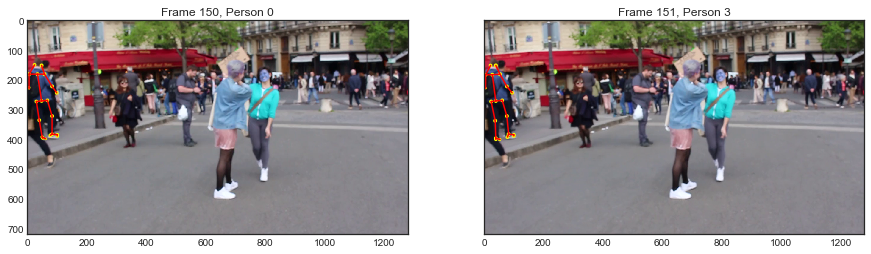

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
ax = ax.flatten()

video = cv2.VideoCapture('./data/openpose/video.avi')

# fast forward
for i in range(150):
    _, image = video.read()
_, image1 = video.read() # frame 150
_, image2 = video.read() # frame 151

df1 = keypoints_to_dataframe(frame1['people'][0]['pose_keypoints_2d'])
ax[0].scatter(df1.x, df1.y, s=df1.c*10, color='yellow')
ax[0].set(title='Frame 150, Person 0')
ax[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
draw_skeleton(ax[0], df1)

df2 = keypoints_to_dataframe(frame2['people'][3]['pose_keypoints_2d'])
ax[1].scatter(df2.x, df2.y, s=df2.c*10, color='yellow')
ax[1].set(title='Frame 151, Person 3')
ax[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
draw_skeleton(ax[1], df2)

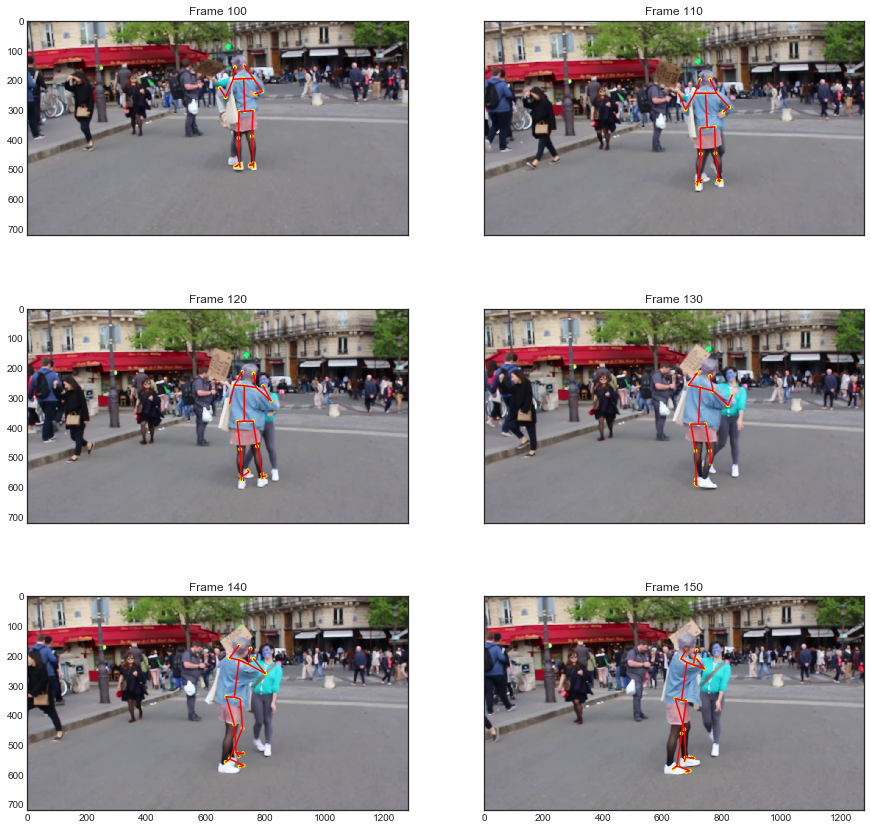

In [18]:
# Extending this further, you should be able to now trace the trajectory of the person
# We will do this every 10 frames

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
ax = ax.flatten()

offset = 100
interval = 10

video = cv2.VideoCapture('./data/openpose/video.avi')

# fast forward
for i in range(offset):
    _, image = video.read()

frame = json.load(open(f'./data/openpose/video_000000000{offset}_keypoints.json', 'rb'))
df = keypoints_to_dataframe(frame['people'][0]['pose_keypoints_2d'])
centroid = get_centroid(df)

for i in range(0, 60, interval):
    _, image = video.read()
        
    frame = json.load(open(f'./data/openpose/video_000000000{offset+i}_keypoints.json', 'rb'))
    index = get_closest_index(centroid, frame) # find the closest person
    
    # load keypoints for the closest person
    df = keypoints_to_dataframe(frame['people'][index]['pose_keypoints_2d'])
    
    axis = ax[i//interval]
    axis.scatter(df.x, df.y, s=df.c*10, color='yellow')
    axis.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axis.set(title=f'Frame {offset+i}')
    draw_skeleton(axis, df)
    
    for j in range(interval):
        _, image = video.read() # fast forward
        
    centroid = get_centroid(df) # update centroid since person may have moved

## <font color='red'>Exercise</font>

1. Record a video of yourself doing your favourite activity (walking, waving, jumping, dancing - your choice!). If you prefer not to record a video due to privacy reasons, you can download a sample video. The video can be in AVI or MP4.

   Try a site such as: https://www.videvo.net/free-stock-footage/people/ for free videos of people.


2. Generate keypoints from the video using OpenPose. You do not need the COCO format. Capture at least 10 frames with people.

```
bin\OpenPoseDemo.exe --part_candidates --write_json c:\temp\output --video c:\temp\myvideo.mp4 --frame_first 10 --frame_step 1 --frame_last 30
```


3. Use the keypoints to trace the trajectory. You can start with the code below, which performs trajectory tracking for 6 frames, starting with offset 2. Depending on when a person shows up in the video, you will need to modify the frame offset.

    The result can look something like this:
    ![image](./data/openpose/hkstreet.png)


### <font color='red'>Submission</font>

<font color='red'>Take a screenshot of the result from OpenPose. Submit:
- Your copy of the .ipynb showing your result.
- A link to the video you used.
</font>

#### Code for Exercise:

1. Change the paths `video_path` and `keypoints_path` to your video
2. Change the `offset` to where the person you want to track is appearing

In [ ]:
# Code for extracting 
# 6 frames
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
ax = ax.flatten()

# modify this to start at the frame where people are in the video
offset = 2
interval = 1

# path to the video. avi, mp4 have been tested
# Example (https://www.videvo.net/video/pedestrians-crossing-street-in-hong-kong/8152/)
# video_path = 'd:/temp/example/180301_03_A_CausewayBay_06.mp4'

############# CHANGE BELOW PATH ################
video_path = 'myvideo.mp4'
############# CHANGE ABOVE PATH ################

# keypoints files usually contain the video name as prefix
# Example:
# keypoints_path = 'd:/temp/example/output/180301_03_A_CausewayBay_06'
############# CHANGE BELOW PATH ################
keypoints_path = 'myvideo'
############# CHANGE ABOVE PATH ################

video = cv2.VideoCapture(video_path)

# fast forward to offset
for i in range(offset):
    _, image = video.read()

frame = json.load(open(f'{keypoints_path}_00000000000{offset}_keypoints.json', 'rb'))
df = keypoints_to_dataframe(frame['people'][0]['pose_keypoints_2d'])
centroid = get_centroid(df)

for i in range(0, 6, interval):
    _, image = video.read()
        
    frame = json.load(open(f'{keypoints_path}_00000000000{offset+i}_keypoints.json', 'rb'))
    index = get_closest_index(centroid, frame) # find the closest person
    
    # load keypoints for the closest person
    df = keypoints_to_dataframe(frame['people'][index]['pose_keypoints_2d'])
    
    axis = ax[i//interval]
    axis.scatter(df.x, df.y, s=df.c*10, color='yellow')
    axis.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axis.set(title=f'Frame {offset+i}')
    draw_skeleton(axis, df)
    
    centroid = get_centroid(df) # update centroid since person may have moved